#### Minimalist implementation of DPM for the swiss roll dataset with tensorflow/Keras.

* Original paper [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585)
* Original source code https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models

Highly recommended links

* In depth overview:
 - https://lilianweng.github.io/lil-log/2021/07/11/diffusion-models.html
 - https://yang-song.github.io/blog/2021/score/

* PyTorch implementation which has more in depth cover of score matching, Langevin dynamics and connection to WaveGrad https://github.com/acids-ircam/diffusion_models


In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, Concatenate, Reshape

from sklearn.datasets import make_swiss_roll

#### Generate and normalize data

In [2]:
n_samples = 10000

In [3]:
data, _ = make_swiss_roll(n_samples, noise=.1)

In [4]:
x0 = data[:,[0,2]]

In [5]:
x0 = (x0 - x0.mean(axis=0)) / x0.std(axis=0)

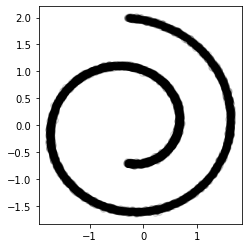

In [6]:
plt.scatter(x0[:,0], x0[:,1], c="black", alpha=0.1)
ax = plt.gca()
ax.set_aspect('equal');

In [7]:
diffusion_steps = 40

#### Fixed shedule for $\beta_{t}$
* In the original paper the betas were learned. Fixed schedule for the binomial heart-beat distribution was mentioned as feasible solution. For simplicity we are going to resort to that fixed schedule $\beta_{t} = (T - t + 1)^{-1}$

$\beta_{t}$ schedule

In [8]:
def beta_schedule(n_steps):
    n_steps = float(n_steps)
    return tf.convert_to_tensor([0.1*(n_steps - t + 1)**-1 for t in np.arange(n_steps)], dtype=tf.float32)

In [9]:
beta_schedule = beta_schedule(diffusion_steps)

$\alpha_{t}$ schedule

In [10]:
alpha_schedule = 1.0 - beta_schedule

$\bar{\alpha_{t}}$ schedule, this is the cummulitive alpha which allows us to sample from $q(x_{t}|x_{0}, t)$

In [11]:
alpha_cum_forward_schedule = tf.math.cumprod(alpha_schedule)

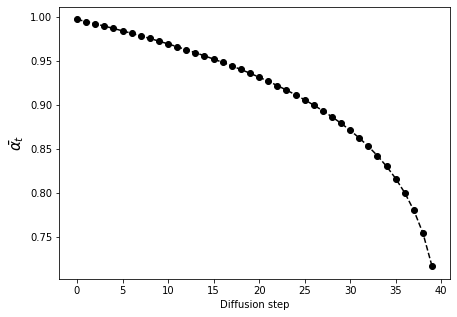

In [12]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(diffusion_steps), alpha_cum_forward_schedule, "--o", c="black")
plt.xlabel("Diffusion step")
plt.ylabel(r'$\bar{\alpha_{t}}$', fontsize=15);

#### Diffuse sub sample of the data (forward trajectory, demonstraion purposes)

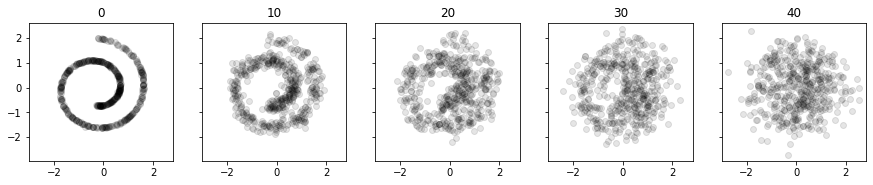

In [13]:
x_sample = x0[:500, :]
fig, axes = plt.subplots(ncols=5, sharey=True, sharex=True, figsize=(15,5))
for i, t in enumerate([0, 10, 20, 30, 40]):
    alpha_cum_forward = np.concatenate([[1.0], alpha_cum_forward_schedule])[t]
    x_corrupted = x_sample * np.sqrt(alpha_cum_forward) + np.sqrt(1 - alpha_cum_forward) * np.random.randn(*x_sample.shape)
    axes[i].scatter(x_corrupted[:,0], x_corrupted[:,1], c="black", alpha=0.1)
    axes[i].set_aspect("equal")
    axes[i].set_title(str(t))

#### Forward process, select number of steps $t$ and return it alongside with $x_{t}$, posterior $\mu$ and $\sigma$ for $q(x_{t-1}|x_{t}, x_{0})$

In [14]:
def forward(x0, diffusion_steps=40):
    t = np.random.randint(1, diffusion_steps)
    alpha_cum_forward = alpha_cum_forward_schedule[t]
    beta_forward = beta_schedule[t]
    alpha_forward = alpha_schedule[t]

    x_corrupted = x0 * np.sqrt(alpha_cum_forward) + np.sqrt(1 - alpha_cum_forward) * np.random.randn(*x0.shape)
    
    mu1_scl = np.sqrt(alpha_cum_forward / alpha_forward)
    mu2_scl = 1. / np.sqrt(alpha_forward)
    cov1 = 1. - alpha_cum_forward/alpha_forward
    cov2 = beta_forward / alpha_forward
    lam = 1./cov1 + 1./cov2
    mu = (
            x0 * mu1_scl / cov1 +
            x_corrupted * mu2_scl / cov2
        ) / lam
    sigma = np.sqrt(1./lam)
    return x_corrupted, t, mu, sigma

#### Data generator

In [15]:
def generator(data, batch_size):
    n_samples = len(data)
    sampling_index = np.arange(n_samples)
    while True:
        # shuffle at the begining of each epoch
        index_array = np.random.permutation(sampling_index)
        for i in range(0, n_samples, batch_size):
            batch_x = []
            batch_t = []
            batch_mu = []
            batch_sigma = []
            current_index = index_array[i:(i + batch_size)]
            current_x = data[current_index]
            for x in current_x:
                x_corrupted, t, mu, sigma = forward(x, diffusion_steps=diffusion_steps)
                batch_x.append(x_corrupted)
                batch_t.append(t)
                batch_mu.append(mu)
                batch_sigma.append(sigma)

            yield ( np.hstack([np.array(batch_x), np.array(batch_t)[...,np.newaxis]]).astype(np.float32),
            np.hstack([np.array(batch_mu), np.array(batch_sigma)[...,np.newaxis], np.array(batch_t)[...,np.newaxis]]).astype(np.float32))

In [16]:
batch_size = 50

In [17]:
mygen = generator(x0, batch_size)

In [18]:
x, y = next(mygen)

Columns of x are $x_{t}$, $t$; ($x_{t}$ is 2 dimentional).

In [19]:
x[:4,:]

array([[-0.48602316,  1.0274754 , 27.        ],
       [ 0.21053866,  0.6491233 , 22.        ],
       [-1.5891112 ,  0.5886703 , 12.        ],
       [ 0.14504081, -1.0104562 , 21.        ]], dtype=float32)

Columns of y are $\mu$, $\sigma$, $t$ ($\mu$ is 2 dimentional, $\sigma$ is a scalar. Both parameterize $q(x_{t-1}|x_{t}, x_{0})$ distribution)

In [20]:
y[:4,:]

array([[-0.5289275 ,  1.0190835 ,  0.08192324, 27.        ],
       [ 0.20448537,  0.67182386,  0.07023399, 22.        ],
       [-1.595275  ,  0.55622816,  0.05601014, 12.        ],
       [ 0.1530066 , -0.98429596,  0.06841271, 21.        ]],
      dtype=float32)

#### Model $F(x_{t}, t)$ i.e. $f_{\mu}(x_{t}, t)$ and $f_{\Sigma}(x_{t}, t)$
* weights are shared across all timesteps except of the last layer (`means` and `sigmas`) which is timedependent (as enforced through the loss function); we do have to take care of selecting output which correspond to a certain timestep.
* $f_{\Sigma}$ outputs are forced to be between zero and one.
* The paper implemetation used normalized RBF units (any smooth approximator will do)

In [21]:
in_ = Input((3,))
x = Dense(128, activation="relu")(in_)
x = Dense(128, activation="relu")(x)
means = Dense(2 * diffusion_steps)(x)
sigmas = Dense(2 * diffusion_steps, activation="sigmoid")(x)
means = Reshape((2, 1, diffusion_steps))(means) 
sigmas = Reshape((2, 1, diffusion_steps))(sigmas)
out_ = Concatenate(axis=2)([means, sigmas])
model = tf.keras.Model(inputs=in_, outputs=out_)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          512         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 80)           10320       dense_1[0][0]                    
______________________________________________________________________________________________

#### KL between univarate gaussian distributions

In [23]:
def gaussian_KL(mu, sigma, mu_posterior, sigma_posterior):
    KL = ( tf.math.log(sigma) - tf.math.log(sigma_posterior) + 
          (sigma_posterior**2 + (mu_posterior-mu)**2)/(2*sigma**2)
          - 0.5 )
    return tf.reduce_mean(KL)

#### Loss (we disregard all the entropy terms for simplicity)

In [24]:
def loss(y_true, y_pred):
    batch_loss = 0.0    
    for i in range(batch_size):
        mu_posterior = y_true[i,:2]
        sigma_posterior = y_true[i,2]
        t = tf.cast(y_true[i,3], tf.int32)

        mu_t = y_pred[i,:,0,t]
        sigma_t = y_pred[i,:,1,t]

        batch_loss += gaussian_KL(mu_t, sigma_t, mu_posterior, sigma_posterior)
    return batch_loss/batch_size

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss)

In [26]:
history = model.fit(mygen, batch_size=batch_size, steps_per_epoch=int(n_samples/batch_size),
                    verbose=0, epochs=2500)

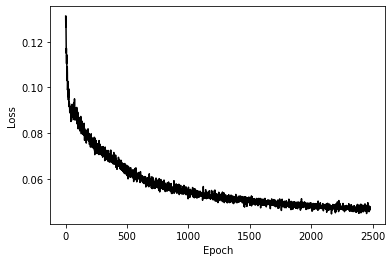

In [27]:
plt.plot(history.history["loss"][20:], c="black")
plt.xlabel("Epoch")
plt.ylabel("Loss");

#### Learned gradient for $t = 1$ (drift: $f_{\mu}(x_{t}, t) - x_{t}$)

In [28]:
grid = np.linspace(-2, 2)

In [29]:
t = 1
drift = []
xy = []
for yi in grid:
    for xi in grid:
        xy.append(np.array([xi, yi]))   
        pred = model(np.array([[xi, yi, t]]))
        x_p, y_p = pred[0,:,0,t].numpy()
        drift.append(np.array([x_p - xi, y_p - yi]))

In [30]:
xy = np.array(xy)
drift = np.array(drift)

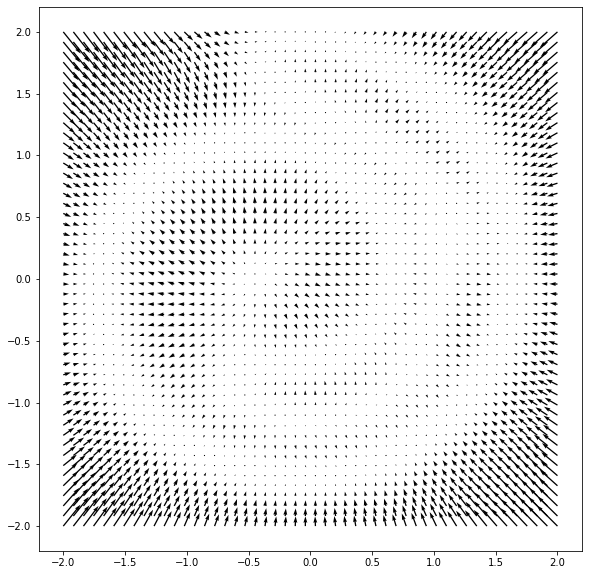

In [31]:
plt.figure(figsize=(10, 10))
plt.quiver(xy[:,0], xy[:,1], drift[:,0], drift[:,1])
ax = plt.gca()
ax.set_aspect('equal')

#### Sample data (Reverse process)

In [32]:
sample_size = (500, 2)

In [33]:
x_isotropic = np.random.randn(*sample_size)

In [34]:
Xmid = x_isotropic.copy()
X_all_steps = []
for t in np.arange(start=diffusion_steps-1, stop=0, step=-1):
    _in = np.hstack([Xmid, (t * np.ones(sample_size[0]))[..., np.newaxis]])
    pred = model(_in)
    mu = pred[:,:,0,t]
    sigma = pred[:,:,1,t]   
    Xmid = mu + sigma * np.random.randn(*sample_size)
    X_all_steps.append(Xmid)

In [35]:
X_all_steps = [x_isotropic] + X_all_steps

#### 

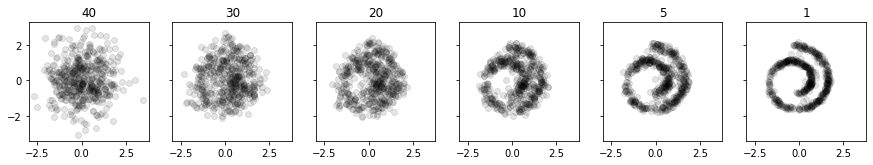

In [36]:
fig, axes = plt.subplots(ncols=6, sharey=True, sharex=True, figsize=(15,5))
for i, t in enumerate([0, 10, 20, 30, 35, 39]):
    axes[i].scatter(X_all_steps[t][:,0], X_all_steps[t][:,1], c="black", alpha=0.1)
    axes[i].set_aspect("equal")
    axes[i].set_title(str(40 - t))